## This project implements the "Image fusion with guided filtering" code described in the article of Shutao Li, Member, Xudong Kang, and Jianwen Hu and available here : https://perso.telecom-paristech.fr/gousseau/MVA/Projets2021/FocusFusion/fusion.pdf

In [2]:
from scipy.ndimage.filters import laplace
from scipy.ndimage import uniform_filter, gaussian_filter
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from math import *
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
def padding(im,r):
    return np.pad(im,((r, r),(r, r)), 'reflect')

# 1.Guided filtering

The guided filter is an edge-preserving filter, and the computing time of which is independent of the filter size. Furthermore, the guided filter is based on a local linear model, making it qualified for other applications such as image matting, up-sampling and colorization.

### For single channel images

The output $O$ of the guided filter is a linear transformation of the guidance image $I$ in a local square window $\omega_k$ of size $(2r+1)\times(2r+1)$, centered at pixel $k$.
\begin{align}\tag{1}
  \forall i\in \omega_k, \quad O_i = a_k I_i + b_k
\end{align}
where $a_k,b_k,I_i\in\mathbb{R}$.

The coefficients $a_k$ and $b_k$, that are constants in window $\omega_k$, minimize the squared difference $E(a_k,b_k)$ between the
output image $O$ and the input image $P$
\begin{align*}
  E(a_k,b_k) &= \sum_{i\in ω_k}\left((O_i - P_i)^2 + ϵa_k^\top a_k\right)\\
  &= \sum_{i\in ω_k}\left((a_k I_i + b_k - P_i)^2 + ϵa_k^2\right).
\end{align*}
This is solved by
\begin{align*}
  a_k &= \frac{1}{\delta_k + \epsilon} \left(\frac{1}{|ω|}\sum_{i\in ω_k}I_i P_i - \mu_k \bar P_k\right)\\
  b_k &= \bar P_k - a_k \mu_k
\end{align*}
where $\mu_k$ and $\delta_k$ are the mean and variance of $I$ in the window $\omega_k$, $|ω|$ is the number of pixels in the window, and $\bar P_k$ is the mean of $P$ in the window $\omega_k$.

All local windows centered at pixel $k$ in the window $ω_i$ contain pixel $i$, and equation $(1)$ will give different values of $O_i$ each time. To solve this issue, all the possible
values of coefficients $a_k$ and $b_k$ are first averaged. Then, the filtering output is estimated as follows:
\begin{align}
  O_i = \bar a_i I_i + \bar b_i
\end{align}
where $\bar a_i = \frac{1}{|ω|}\sum_{k\in ω_i}a_k$ and $\bar b_i = \frac{1}{|ω|}\sum_{k\in ω_i}b_k$.

### If the guidance image $I$ is a color image

If the guidance image $I$ is a color image, equation $(1)$ becomes
\begin{align*}
  \forall i\in \omega_k, \quad O_i = a_k^\top I_i + b_k
\end{align*}
where $a_k\in\mathbb{R}^{3\times1}$, $I_i\in\mathbb{R}^{3\times1}$ (color image) and $b_k\in\mathbb{R}$.

Coefficients $a_k$ and $b_k$ minimize the squared difference $E(a_k,b_k)= \sum_{i\in ω_k}\left((a_k^\top I_i + b_k - P_i)^2 + ϵa_k^\top a_k\right)$ and are given by
\begin{align*}
  a_k &= (Σ_k + ϵU) \left(\frac{1}{|ω|}\sum_{i\in ω_k}P_iI_i - \mu_k \bar P_k\right)\\
  b_k &= \bar P_k - a_k^\top \mu_k
\end{align*}
where $Σ_k$ is the $3 × 3$ covariance matrix of $I$ in $ω_k$, and $U$ is the $3 × 3$ identity matrix.

The final output image is then given by $O_i = \bar a_i I_i + \bar b_i$ similarly to what precedes.


### If the input image $P$ is a color image

When the input is a color image, the filtering
output is obtained by conducting the guided filtering on the red, green, and blue channels of the input image,
respectively.

## Implementation

In [4]:
def guided_filter(im,guide,r,epsilone):
    im = np.array(im, np.float32)
    a = np.zeros((im.shape[0],im.shape[1]), np.float32)
    b = np.zeros((im.shape[0],im.shape[1]), np.float32)
    O = np.array(im, np.float32, copy=True)
    im=padding(im,r)
    guide=padding(guide,r)   
    n=np.shape(im)[0]
    m=np.shape(im)[1] 
    a_k = np.zeros((n,m), np.float32)
    b_k = np.zeros((n,m), np.float32)
    w=2*r+1
    for i in range(r,n-r):
        for j in range(r,m-r): 
            I=guide[i-r:i+r+1 ,j-r:j+r+1 ]
            P=im[i-r:i+r+1 ,j-r:j+r+1 ]
            mu_k = np.mean(I)
            delta_k = np.var(I)
            P_k_bar = np.mean(P)
            somme = np.dot(np.ndarray.flatten(I), np.ndarray.flatten(P))/(w**2)
            a_k[i,j] = (somme - mu_k * P_k_bar) / (delta_k + epsilone)
            b_k[i,j] = P_k_bar - a_k[i,j] * mu_k   
    a=a_k[r:n-r+1,r:m-r+1]
    b=b_k[r:n-r+1,r:m-r+1]
    a=padding(a,r)
    b=padding(b,r)
    for i in range(r, n-r):
        for j in range(r, m-r):
            a_k_bar = a[i-r : i+r+1, j-r : j+r+1].sum()/(w*w)
            b_k_bar = b[i-r : i+r+1, j-r : j+r+1].sum()/(w*w)
            O[i-r,j-r] = a_k_bar * guide[i,j] + b_k_bar
    return O

#  2.Image fusion with guided filtering

In this section, the guided filter is applied for image fusion. First, an average filter is used to get the two-scale representations (base layer + detail layer). Then, the base and detail layers are fused through using a guided filtering based weighted average method.

### Two-scale image decomposition

The two-scale decomposition step aims at separating each source image into a base layer containing the large-scale variations in intensity and a detail layer containing the small scale details.

The base layer $B_n$ of each source image is obtained by average filtering:
$$B_n = I_n ∗ Z$$
where $I_n$ is the $n$th source image, $Z$ is the average filter, and the size of the average filter is conventionally set to $31 × 31$.

Then, the detail layer $D_n$ can be easily obtained by subtracting the base layer from the source image:
$$D_n = I_n − B_n$$.

### Weight map construction with guided filtering

The weight map construction can be decomposed in four steps.

1. Laplacian filtering is applied to each source image to obtain the high-pass image $H_n$
$$H_n = I_n ∗ L$$
where $L$ is a $3 × 3$ Laplacian filter.

2. Local average of the absolute value of $H_n$ is used to construct the saliency maps $S_n$
$$S_n = |H_n| ∗ g_{r_g,σ_g}$$
where $g$ is a Gaussian low-pass filter of size
$(2r_g + 1)\times(2r_g + 1)$, and the parameters $r_g$ and $σ_g$ are set to 5.

3. Saliency maps are compared to determine the weight maps
$$P_n^k = \begin{cases}1 \quad\text{if}\quad S_n^k = \max(S_1^k,\ldots,S_N^k)\\ 0 \quad\text{otherwise}\end{cases}$$
where $N$ is number of source images, and $S_n^k$ is the saliency value of the pixel $k$ in the $n$th image.

4. The weight maps obtained above are usually noisy and not aligned with object boundaries, which may produce artifacts to the fused image. Using spatial consistency is an effective way to solve this problem. Guided image filtering is performed on each weight map $P_n$ with the corresponding source image $I_n$ serving as the guidance image.
\begin{align*}
W_n^B &= G_{r_1,\epsilon_1} (P_n, I_n)\\
W_n^D &= G_{r_2,\epsilon_2} (P_n, I_n)
\end{align*}
where $r_1$, $\epsilon_1$, $r_2$, and $\epsilon_2$ are the parameters of the guided filter, $W_n^B$ and $W_n^D$ are the resulting weight maps of the base and detail layers.

5. The values of the $N$ weight maps are normalized such that they sum to one at each pixel k.

### Two-scale image reconstruction

Two-scale image reconstruction consists of the following two steps.

1. The base and detail layers of different source images are fused together by weighted averaging
\begin{align*}
\bar B &= \sum_{n=1}^N W_n^B B_n\\
\bar D &= \sum_{n=1}^N W_n^D D_n.
\end{align*}

2. The fused image $F$ is obtained by combining the fused base layer $\bar B$ and the fused detail layer $\bar D$
$$F = \bar B + \bar D.$$

## Implementation 

In [5]:
def fusion(im1,im2,scipy_guided_filter=True,r_1=45,r_2=7,eps_1=0.3,eps_2=10e-6):
    sigma_r = 5
    average_filter_size=31
    
    if im1.max()>1:
        im1=im1/255
    if im2.max()>1:
        im2=im2/255
    
    # PART A : TWO SCALE IMAGE DECOMPOSITION :
    
    """Page 10/11 article : the source images are first decomposed
    into two-scale representations by average filtering. 
    Once the base layer is obtained, the detail layer can be easily
    obtained by subtracting the base layer from the source image.
    The two-scale decomposition step aims at separating each
    source image into a base layer containing the large-scale
    variations in intensity and a detail layer containing the small scale details."""
    
    im1_blue, im1_green, im1_red = cv2.split(im1)
    im2_blue, im2_green, im2_red = cv2.split(im2)
    
    base_layer1 = uniform_filter(im1, mode='reflect',size=average_filter_size)
    b1_blue, b1_green, b1_red = cv2.split(base_layer1)
    base1=np.float32(cv2.merge((b1_blue, b1_green, b1_red)))
    
    base_layer2 = uniform_filter(im2, mode='reflect',size=average_filter_size)
    b2_blue, b2_green, b2_red = cv2.split(base_layer2)
    base2=np.float32(cv2.merge((b2_blue, b2_green, b2_red)))
    
    detail_layer1 = im1 - base_layer1
    d1_blue, d1_green, d1_red = cv2.split(detail_layer1)
    detail1=np.float32(cv2.merge((d1_blue, d1_green, d1_red)))
    
    detail_layer2 = im2 - base_layer2
    d2_blue, d2_green, d2_red = cv2.split(detail_layer2)
    detail2=np.float32(cv2.merge((d2_blue, d2_green, d2_red)))
    
    # PART B : Weight Map Construction With Guided Filtering
    
    """The weight map is constructed as
    follows. First, Laplacian filtering is applied to each source
    image to obtain the high-pass image Hn. Then, the local average
    of the absolute value of Hn is used to construct the saliency
    maps Sn."""
    
    saliency1 = gaussian_filter(abs(laplace(im1_blue+im1_green+im1_red,mode='reflect')),sigma_r,mode='reflect')
    saliency2 = gaussian_filter(abs(laplace(im2_blue+im2_green+im2_red,mode='reflect')),sigma_r,mode='reflect')
    
    """Next, the saliency
    maps are compared to determine the weight maps"""
    
    mask = np.float32(np.argmax([saliency1, saliency2], axis=0))
    
    im1=np.float32(im1)
    im2=np.float32(im2)
    
    """However, the weight maps
    obtained above are usually noisy and not aligned with object
    boundaries (see Fig. 3), which may produce artifacts to the
    fused image. Using spatial consistency is an effective way
    to solve this problem. Guided image filtering is performed on
    each weight map Pn with the corresponding source image In
    serving as the guidance image""" 
    
    if (scipy_guided_filter==False) :
        
        g1r1 = guided_filter(1 - mask, im1[:,:,0], r_1, eps_1)+guided_filter(1 - mask, im1[:,:,1], r_1, eps_1)+guided_filter(1 - mask, im1[:,:,2], r_1, eps_1)
        g2r1 = guided_filter(mask, im2[:,:,0], r_1, eps_1)+guided_filter(mask, im2[:,:,1], r_1, eps_1)+guided_filter(mask, im2[:,:,2], r_1, eps_1)
        g1r2 = guided_filter(1 - mask, im1[:,:,0], r_2, eps_2)+ guided_filter(1 - mask, im1[:,:,1], r_2, eps_2)+ guided_filter(1 - mask, im1[:,:,2], r_2, eps_2)
        g2r2 =  guided_filter(mask, im2[:,:,0], r_2, eps_2)+ guided_filter(1 - mask, im2[:,:,1], r_2, eps_2)+ guided_filter(1 - mask, im2[:,:,2], r_2, eps_2)

    else :
        
        gf1 = cv2.ximgproc.createGuidedFilter(im1, r_1, eps_1)
        gf2 = cv2.ximgproc.createGuidedFilter(im2, r_1, eps_1)  
        gf3 = cv2.ximgproc.createGuidedFilter(im1, r_2, eps_2)
        gf4 = cv2.ximgproc.createGuidedFilter(im2, r_2, eps_2)
        
        g1r1 = gf1.filter(1 - mask)
        g2r1 = gf2.filter(mask)
        g1r2 = gf3.filter(1-mask)
        g2r2 = gf4.filter(mask)
        
    #PART C : Two-Scale Image Reconstruction
    
    """Two-scale image reconstruction consists of the following
    two steps. First, the base and detail layers of different source
    images are fused together by weighted averaging"""
    
    fused_base1 = np.float32((b1_blue * (g1r1) + b2_blue * (g2r1))/((g1r1+g2r1)))          
    fused_detail1 = np.float32((d1_blue * (g1r2) + d2_blue * (g2r2))/((g1r2+g2r2)))  
    fused_base2 = np.float32((b1_green * g1r1 + b2_green * g2r1)/((g1r1+g2r1)))   
    fused_detail2 = np.float32((d1_green * (g1r2) + d2_green * (g2r2))/((g1r2+g2r2)))    
    fused_base3 = np.float32((b1_red * (g1r1) + b2_red * (g2r1))/((g1r1+g2r1)))
    fused_detail3 = np.float32((d1_red * (g1r2) + d2_red * (g2r2))/((g1r2+g2r2)))
        
    """Then, the fused image F is obtained by combining the fused
    base layer B and the fused detail layer D"""
    
    B1=np.float32(fused_base1+fused_detail1)
    B2=np.float32(fused_base2+fused_detail2)
    B3=np.float32(fused_base3+fused_detail3)
    
    fusion1=np.float32(cv2.merge((B1, B2, B3)))
    fusion1=fusion1/fusion1.max()
    
    return fusion1,base1,detail1,saliency1,saliency2,1-mask,g1r1

# 3. Results and discussion

### Dataset used for testing the method

We test the method on 6 pairs of images. For each pair, a different zone of the image is blurred.

In [6]:
path = ('C:\\Users\\gabri\\OneDrive\\Bureau\\Documents\\MVA\\Numerical_Image\\Image_fusion_dataset\\')

In [7]:
desert1 = plt.imread(path+"desert1.jpg")
desert2 = plt.imread(path+"desert2.jpg")
poteau1 = plt.imread(path+"poteau1.jpg")
poteau2 = plt.imread(path+"poteau2.jpg")
ours1 = plt.imread(path+"ours1.jpg")
ours2 = plt.imread(path+"ours2.jpg")
musee1 = plt.imread(path+"musee1.jpg")
musee2 = plt.imread(path+"musee2.jpg")
flower1=plt.imread(path+"flower1.jpg")
flower2=plt.imread(path+"flower2.jpg")
woman1=plt.imread(path+"woman1.jpg")
woman2=plt.imread(path+"woman2.jpg")

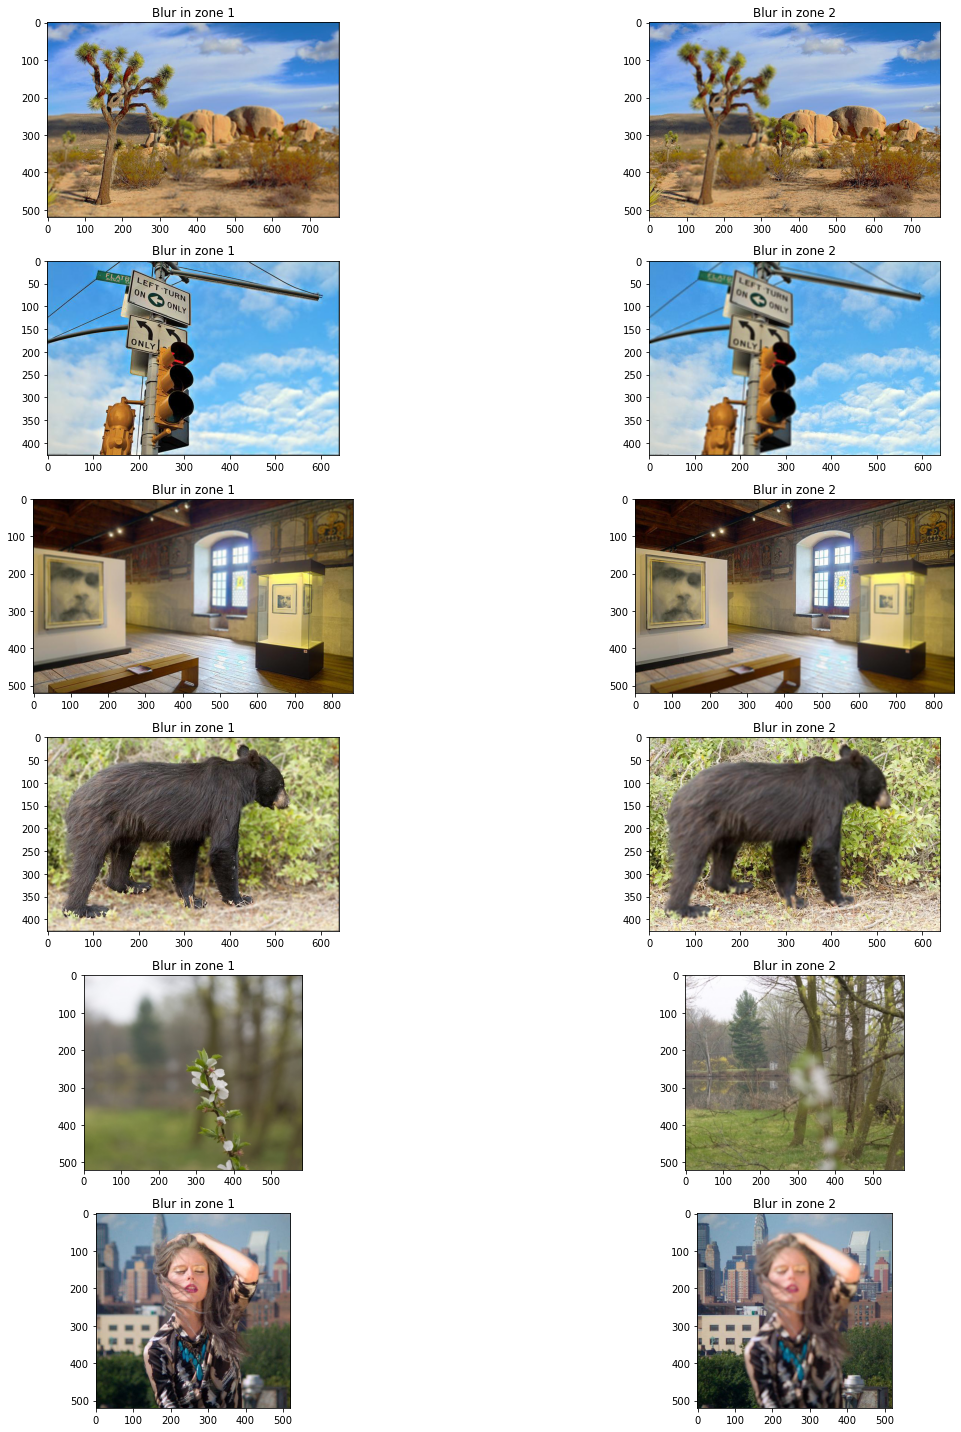

In [8]:
# Each image is blurred in a place and clear in the rest
def show_dataset(images):
    fig, axes = plt.subplots(nrows=len(images)//2, ncols=2, figsize=(20, 20))
    for i in range(len(images)):
        if (i%2==0):
            axes[i//2,i%2].set_title('Blur in zone 1')
        else :
            axes[i//2,i%2].set_title('Blur in zone 2')
        axes[i//2,i%2].imshow(images[i])
    fig.tight_layout()
    plt.show()
show_dataset([desert1,desert2,poteau1,poteau2,musee1,musee2,ours1,ours2,flower1,flower2,woman1,woman2])

## Do the fusion then plot results

In [9]:
# Image fusion
# It takes a few seconds using cv2 guided_filtering function, but several minutes using the guided_filtering function
# we implemented. (Replace True by False to use our function)

desert_fusion=fusion(desert1,desert2,True)[0]

In [477]:
musee_fusion=fusion(musee1,musee2,True)[0]

In [478]:
poteau_fusion=fusion(poteau1,poteau2,True)[0]

In [479]:
ours_fusion=fusion(ours1,ours2,True)[0]

In [366]:
flower_fusion=fusion(flower1,flower2,True)[0]

In [367]:
woman_fusion=fusion(woman1,woman2,True)[0]

In [501]:
# Each image is blurred in a place and clear in the rest
def show_fusion(im1,im2,a1): 
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
    axes[0].set_title('Blur in zone 1')
    axes[0].imshow(im1)
    axes[1].set_title('Blur in zone 2')
    axes[1].imshow(im2)
    axes[2].set_title('No blur')
    axes[2].imshow(a1)
    fig.tight_layout()
    plt.show()


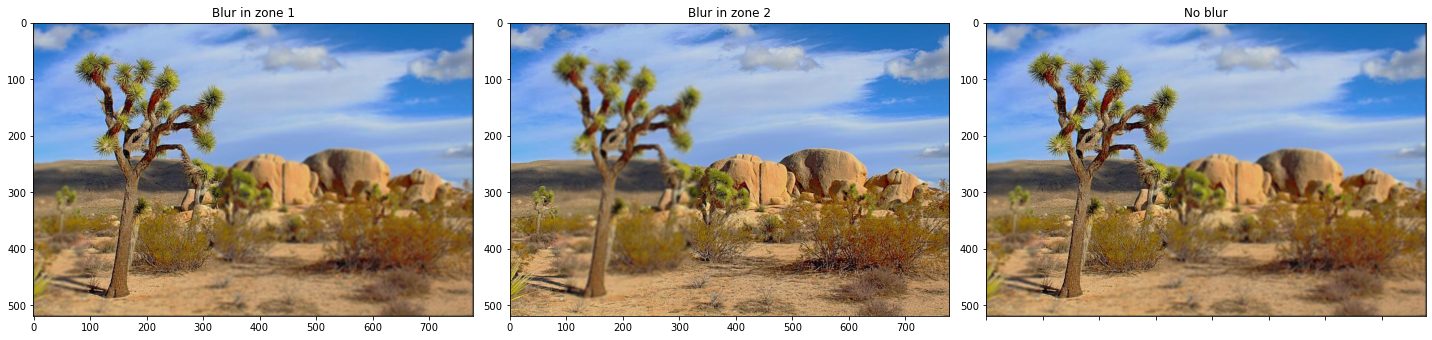

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


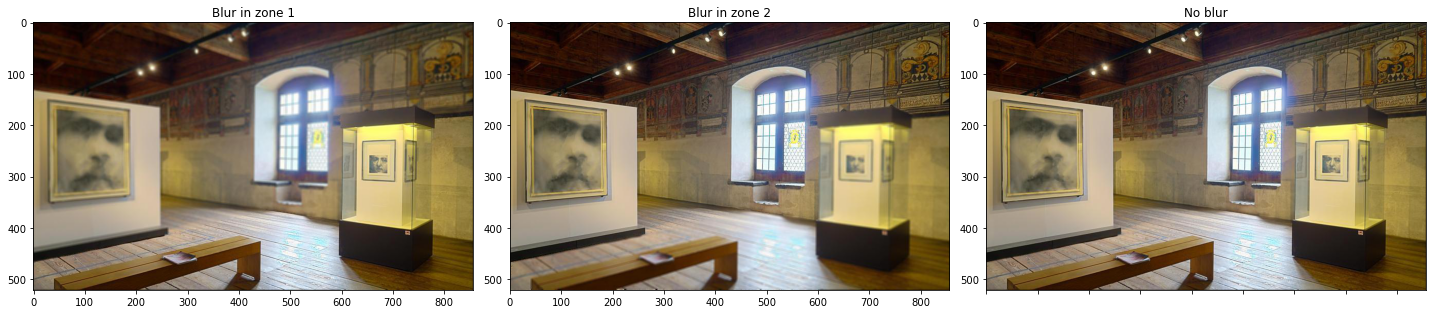

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


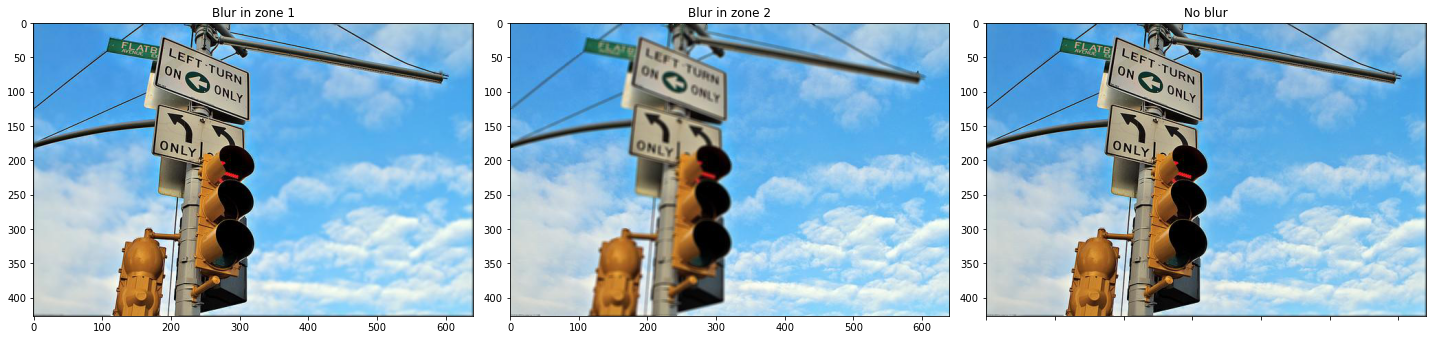

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


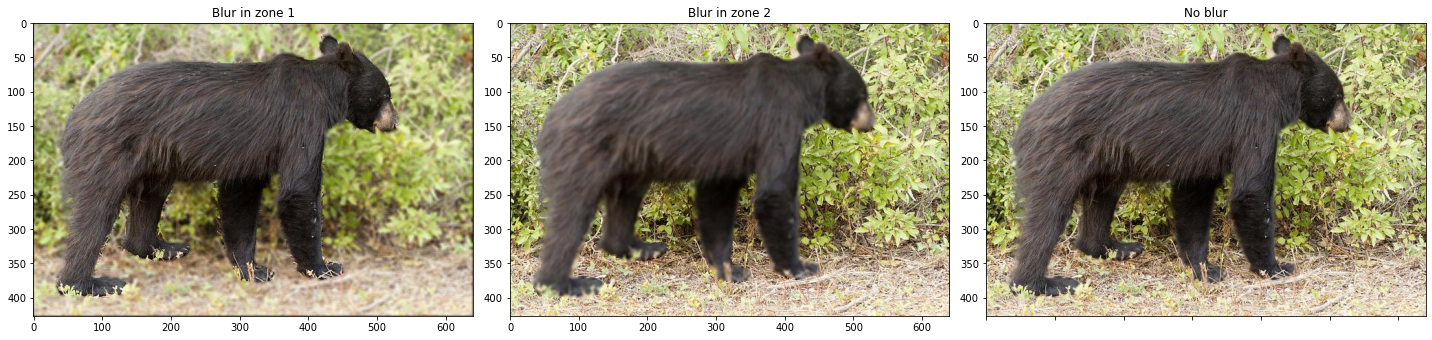

In [500]:
show_fusion(desert1,desert2,desert1)
show_fusion(musee1,musee2,musee_fusion)
show_fusion(poteau1,poteau2,poteau_fusion)
show_fusion(ours1,ours2,ours_fusion)

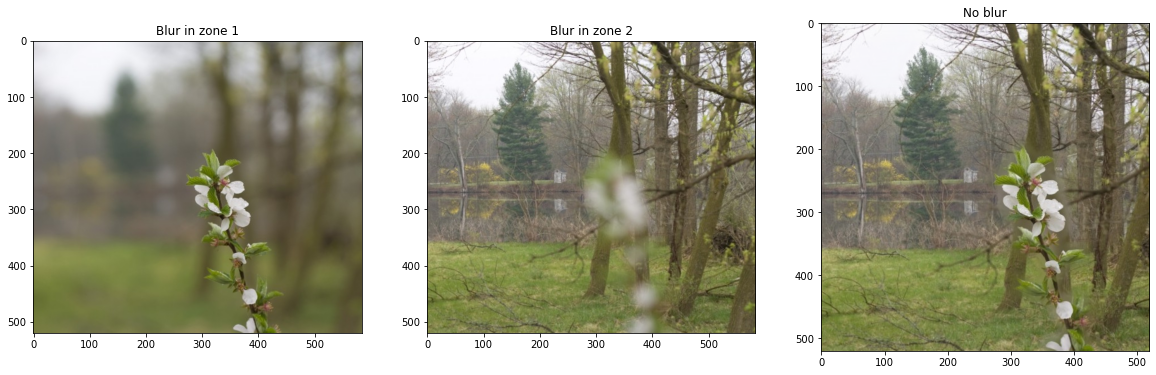

In [498]:
show_fusion(flower1,flower2,flower_fusion)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


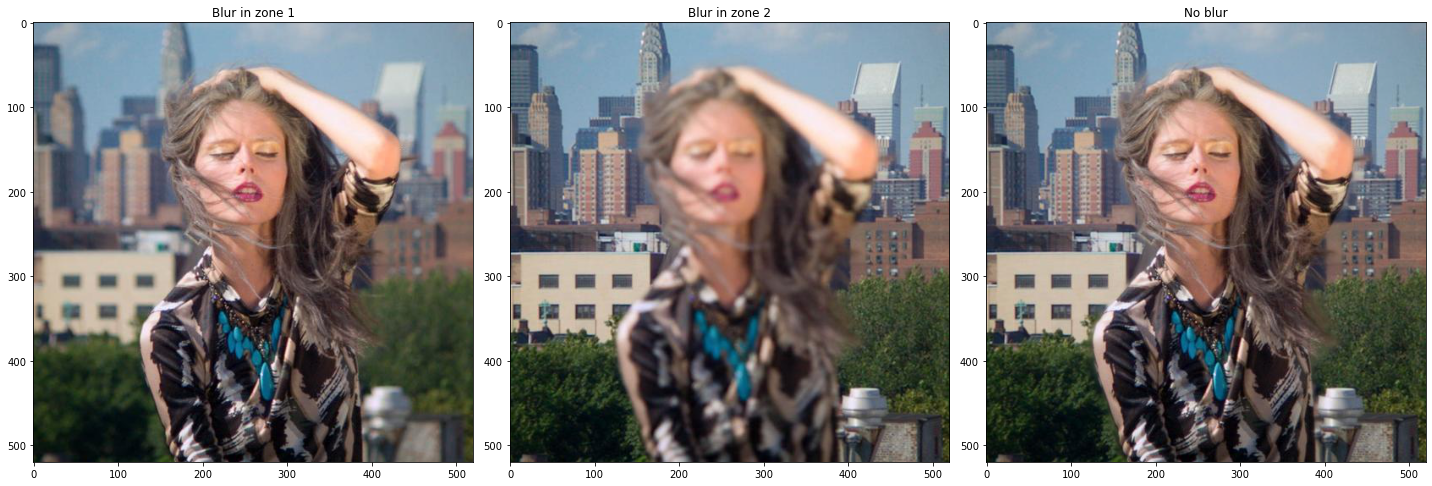

In [492]:
show_fusion(woman1,woman2,woman_fusion)

## Show the different maps computed in the fusion process

In [502]:
def show_steps(im1,im2): 
    im_fusion,base,detail,saliency1,saliency2,weightmap,weightmap_guided=fusion(im1,im2,True)
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
    axes[0,0].set_title('Image 1')
    axes[0,0].imshow(im1)
    axes[0,1].set_title('Image 2')
    axes[0,1].imshow(im2)
    axes[0,2].set_title('Fusion')
    axes[0,2].imshow(im_fusion)
    axes[1,0].set_title('Base image 1')
    axes[1,0].imshow(base)
    axes[1,1].set_title('Detail image 1')
    axes[1,1].imshow(detail)
    axes[1,2].set_title('Saliency map image 1')
    axes[1,2].imshow(saliency1)
    axes[2,0].set_title('Saliency map image 2')
    axes[2,0].imshow(saliency2)
    axes[2,1].set_title('Weight map image 1')
    axes[2,1].imshow(weightmap)
    axes[2,2].set_title('Weight map after guided filtering')
    axes[2,2].imshow(weightmap_guided)
    fig.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


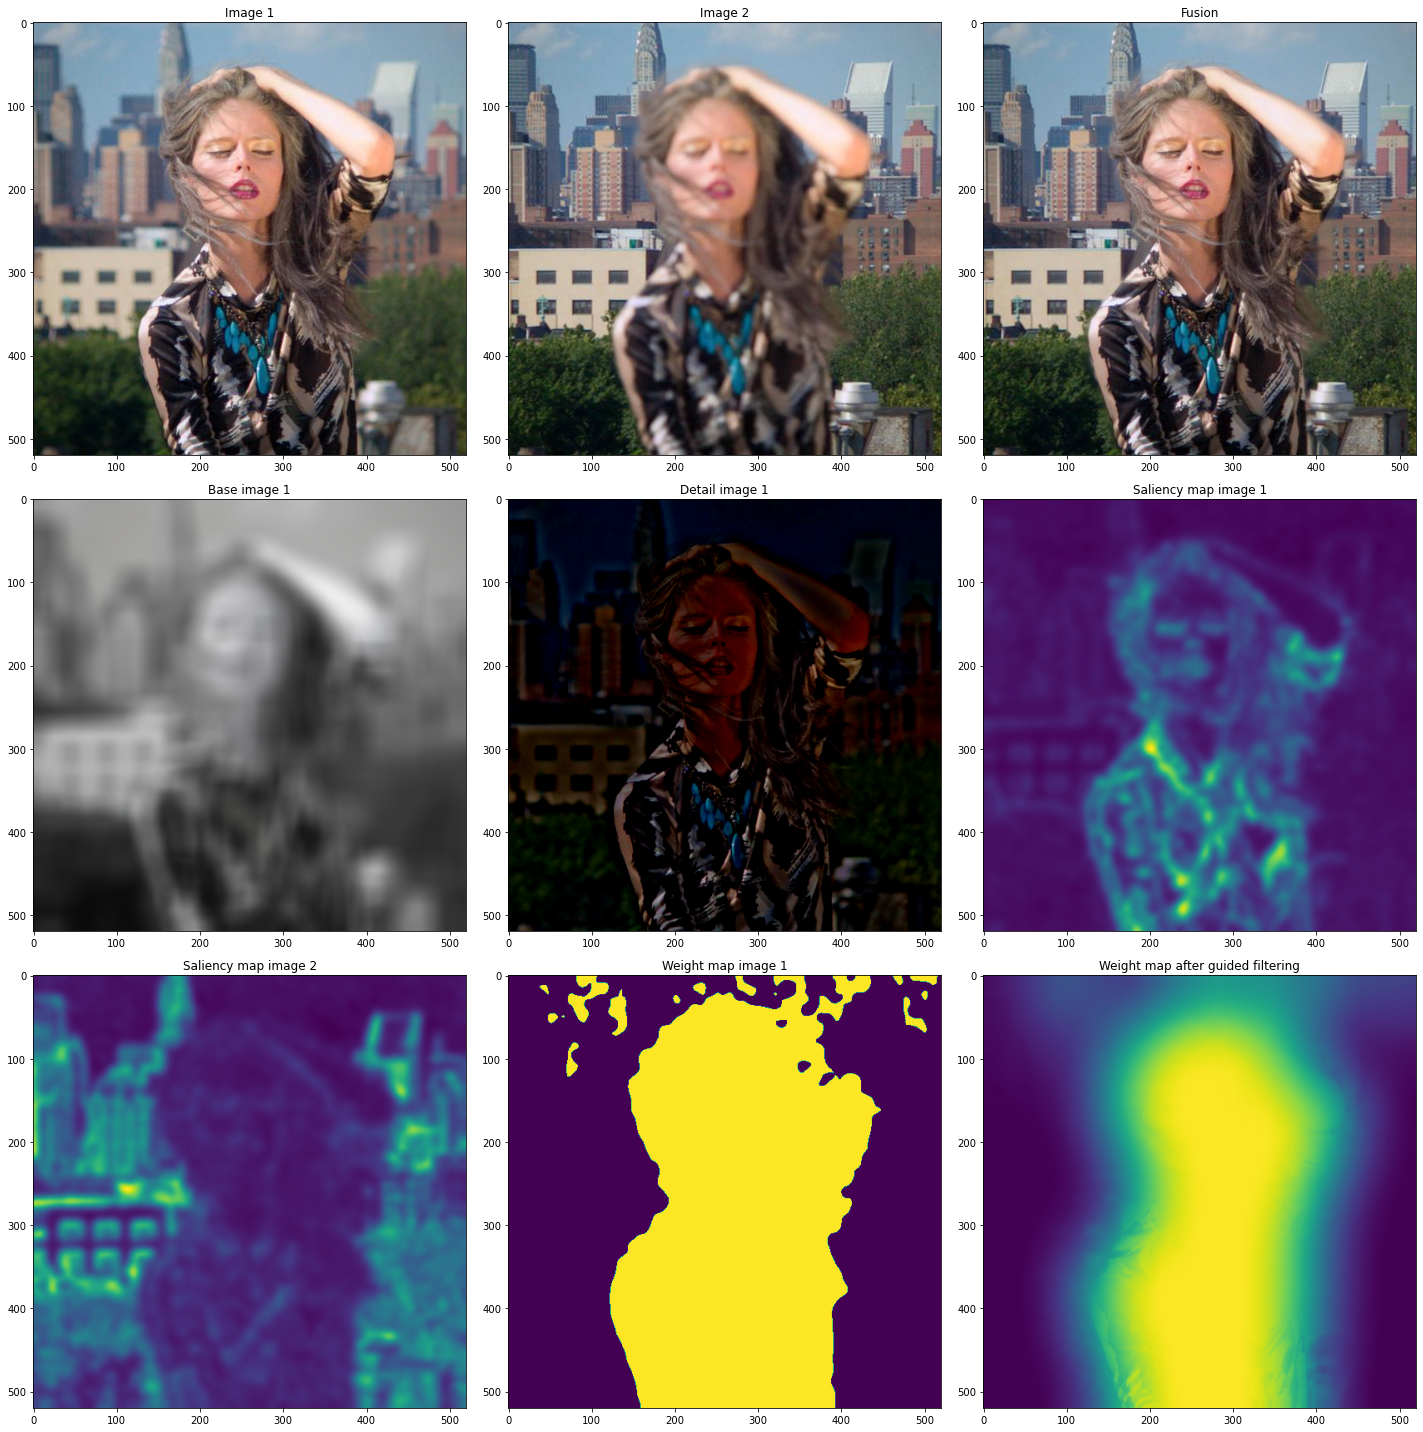

In [503]:
show_steps(woman1,woman2)

## Parameter analysis

In [10]:
import numpy as np
from math import exp, pi
from scipy.ndimage import gaussian_filter
from cv2 import cartToPolar, Sobel, CV_32F
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error

#### As explained in the first paragraph, two parameters of the Guided filter are the filter size $r$ and the blur degree $\epsilon$. We are going to assess the influence of these parameters on the quality of the fusion of the two images of a woman. As guided filterings is performed for the detailed and based image, there is in fact a choice of 4 parameters $r_1,\epsilon_1,r_2,\epsilon_2$. 
We first reproduce two metrics used in the article to assess the quality of fusion, the mutual information and the gradient based index.

In [462]:
EPS = np.finfo(float).eps
GAMMA1 = 1
GAMMA2 = 1
K1 = -10
K2 = -20
DELTA1 = 0.5
DELTA2 = 0.75
L = 1
EPS = np.finfo(float).eps
GAMMA1 = 1
GAMMA2 = 1
K1 = -10
K2 = -20
DELTA1 = 0.5
DELTA2 = 0.75
L = 1

def _sobel_edge_detection(image, verbose=False):
    sx = Sobel(image, CV_32F, 1, 0)
    sy = Sobel(image, CV_32F, 0, 1)
    if verbose:
        plt.imshow(sx, cmap='gray')
        plt.title("Horizontal Edge")
        plt.show()

        plt.imshow(sy, cmap='gray')
        plt.title("Vertical Edge")
        plt.show()
    return cartToPolar(sx, sy)

def _strenght_n_orientation(image):
    s_x, s_y = _sobel_edge_detection(image)
    g = np.sqrt(s_x**2 + s_y**2)
    alpha = np.arctan(s_y / ( s_x + EPS))
    return (g, alpha)

def _perceptual_loss(gA, gF, alphaA, alphaF):
    
    x, y = gA.shape
    g_AF = np.zeros((x,y))
    for n in range(x):
        for m in range(y):
            if (gA[n][m]  > gF[n][m]):
                g_AF[n][m] = gF[n][m] / ( gA[n][m] + EPS)
            else:
                g_AF[n][m] = gA[n][m] / ( gF[n][m] + EPS)
    
    alpha_AF = np.abs( np.abs(alphaA - alphaF) - pi/2) / (pi/2)

    qG_AF = GAMMA1 / (1 + np.exp( K1 *(g_AF - DELTA1)))
    qalpha_AF = GAMMA2 / (1 + np.exp( K2 *(alpha_AF - DELTA2) ))
    q_AF = qG_AF * qalpha_AF
    
    return q_AF

# Gradient information preservation estimates
def xydeas_petrovic_metric(image1, image2, fusedImage):
    # EDGE Strenght and orientation for each pixels of the input images
    gA, alphaA = _strenght_n_orientation(image1)
    gB, alphaB = _strenght_n_orientation(image2)
    gF, alphaF = _strenght_n_orientation(fusedImage)
    
    q_AF = _perceptual_loss(gA, gF, alphaA, alphaF)
    q_BF = _perceptual_loss(gB, gF, alphaB, alphaF)
    
    wA = np.linalg.matrix_power(gA, L)
    wB = np.linalg.matrix_power(gB, L)
    # normalised weighted performance metric QP
    qP_ABF = sum( sum((q_AF * wA + q_BF * wB))) / sum ( sum((wA + wB)))
    
    return qP_ABF

def entropy(image):
    log_image = np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            log_image[i,j] = log(image[i,j]+1e-2)
    entropy=np.sum(image*log_image)
    return entropy

def entropy_2d(origImage,fusedImage):
    bins = (256, 256)
    jh = np.histogram2d(origImage.ravel(), fusedImage.ravel(), bins=bins)[0]
    jh = jh + EPS
    sh = np.sum(jh)
    pi = jh / sh
    entropy = -1 * np.sum(pi * np.log(pi))
    return entropy

def normalized_mutual_information(image1,image2):
    return entropy(image1)+entropy(image2)-entropy_2d(image1,image2)

def mutual_information_gray(image1,image2,fused_image):
    return 2*(normalized_mutual_information(image1,fused_image)/(entropy(image1)+entropy(fused_image)) + 
              normalized_mutual_information(image2,fused_image)/(entropy(image2)+entropy(fused_image)))
            
def mutual_information_rgb(image1,image2,fused_image):
    a=mutual_information_gray(image1[:,:,0],image2[:,:,0],fused_image[:,:,0])
    b=mutual_information_gray(image1[:,:,1],image2[:,:,1],fused_image[:,:,1])
    c=mutual_information_gray(image1[:,:,2],image2[:,:,2],fused_image[:,:,2])
    return (a+b+c)/3

def Gradient_index_rgb(image1,image2,fused_image):
    a=xydeas_petrovic_metric(image1[:,:,0],image2[:,:,0],fused_image[:,:,0])
    b=xydeas_petrovic_metric(image1[:,:,1],image2[:,:,1],fused_image[:,:,1])
    c=xydeas_petrovic_metric(image1[:,:,2],image2[:,:,2],fused_image[:,:,2])
    return a+b+c

In [455]:
def QG_analysis(image1,image2):
    list_r1=[]
    list_r2=[]
    list_eps1=[]
    list_eps2=[]
    for r1 in tqdm([10,20,30,40,50,60]):
        fused_image=fusion(image1,image2,r_1=r1)[0]
        list_r1.append(Gradient_index_rgb(image1,image2,fused_image))
    for r2 in tqdm([10,20,30,40,50,60]):
        fused_image=fusion(image1,image2,r_2=r2)[0]
        list_r2.append(Gradient_index_rgb(image1,image2,fused_image))
    for e1 in tqdm([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]):
        fused_image=fusion(image1,image2,eps_1=e1)[0]
        list_eps1.append(Gradient_index_rgb(image1,image2,fused_image))
    for e2 in tqdm([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]):
        fused_image=fusion(image1,image2,eps_2=e2)[0]
        list_eps2.append(Gradient_index_rgb(image1,image2,fused_image))
    return list_r1,list_r2,list_eps1,list_eps2

def MI_analysis(image1,image2):
    list_r1=[]
    list_r2=[]
    list_eps1=[]
    list_eps2=[]
    for r1 in tqdm([10,20,30,40,50,60]):
        fused_image=fusion(image1,image2,r_1=r1)[0]
        list_r1.append(mutual_information_rgb(image1,image2,fused_image))
    for r2 in tqdm([10,20,30,40,50,60]):
        fused_image=fusion(image1,image2,r_2=r2)[0]
        list_r2.append(mutual_information_rgb(image1,image2,fused_image))
    for e1 in tqdm([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]):
        fused_image=fusion(image1,image2,eps_1=e1)[0]
        list_eps1.append(mutual_information_rgb(image1,image2,fused_image))
    for e2 in tqdm([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]):
        fused_image=fusion(image1,image2,eps_2=e2)[0]
        list_eps2.append(mutual_information_rgb(image1,image2,fused_image))
    return list_r1,list_r2,list_eps1,list_eps2

    

In [453]:
list_r1,list_r2,list_eps1,list_eps2=QG_analysis(woman1,woman2)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:11<00:00, 10.27s/it]


####  When analyzing the influence of $r_1$, other parameters are set to $\epsilon_1 = 0.3, r_2 = 7$, and $\epsilon_2 = 10^{−6}.$ Then, when analyzing the influence of $\epsilon_1$, other parameters are set to $r_1 = 45, r_2 = 7,$ and $\epsilon_2 = 10^{−6}$. $r_2$ and $\epsilon_2$ are analyzed in the same way.

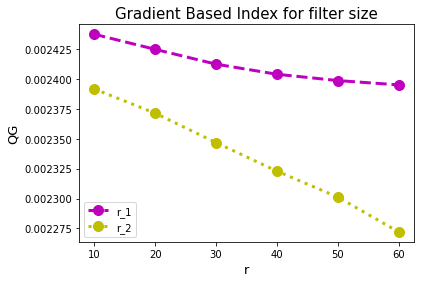

In [518]:
x = [10,20,30,40,50,60]
 
plt.plot(x, list_r1,"mo--", linewidth = 3,
        markersize = 10, label = "r_1")
 
plt.plot(x, list_r2, "yo:", linewidth = 3,
        markersize = 10, label = "r_2")
 
plt.title("Gradient Based Index for filter size", fontsize=15)
plt.xlabel("r",fontsize=13)
plt.ylabel("QG",fontsize=13)
plt.legend(loc = 3)
plt.show()

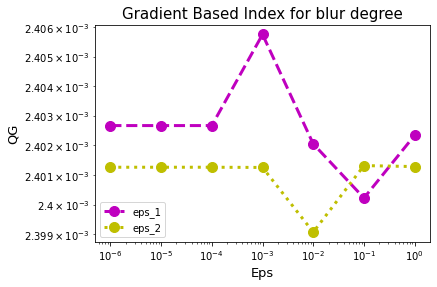

In [519]:
x = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]
 
plt.loglog(x, list_eps1,"mo--", linewidth = 3,
        markersize = 10, label = "eps_1")
 
plt.loglog(x, list_eps2, "yo:", linewidth = 3,
        markersize = 10, label = "eps_2")
 
plt.title("Gradient Based Index for blur degree", fontsize=15)
plt.xlabel("Eps",fontsize=13)
plt.ylabel("QG",fontsize=13)
plt.legend(loc = 3)
plt.show()

In [520]:
mi_list_r1,mi_list_r2,mi_list_eps1,mi_list_eps2=MI_analysis(woman1,woman2)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:10<00:00, 18.60s/it]


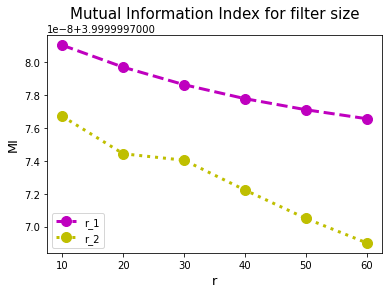

In [523]:
x = [10,20,30,40,50,60]
plt.plot(x, mi_list_r1,"mo--", linewidth = 3,
        markersize = 10, label = "r_1")
 
plt.plot(x, mi_list_r2, "yo:", linewidth = 3,
        markersize = 10, label = "r_2")
 
plt.title("Mutual Information Index for filter size", fontsize=15,y=1.05)
plt.xlabel("r",fontsize=13)
plt.ylabel("MI",fontsize=13)
plt.legend(loc = 3)
plt.show()

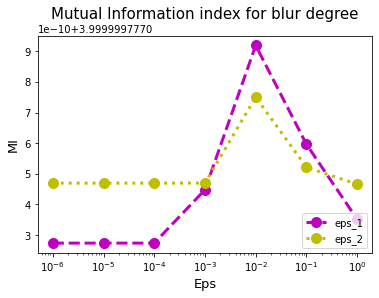

In [525]:
x = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]
 
plt.plot(x, mi_list_eps1,"mo--", linewidth = 3,
        markersize = 10, label = "eps_1")
plt.xscale('log')
plt.plot(x, mi_list_eps2, "yo:", linewidth = 3,
        markersize = 10, label = "eps_2")
plt.xscale('log')
plt.title("Mutual Information index for blur degree", fontsize=15,y=1.05)
plt.xlabel("Eps",fontsize=13)
plt.ylabel("MI",fontsize=13)
plt.legend(loc = 4)
plt.show()